<a href="https://colab.research.google.com/github/ugurcancakal/pytorch-tutorial/blob/master/RNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN in PyTorch II

In [70]:
# @title Imports

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
#@title Video: RNN II

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="1vGOQAel2yU?t", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
print("Code available at https://github.com/hunkim/PyTorchZeroToAll")
video

Video available at https://youtube.com/watch?v=1vGOQAel2yU?t
Code available at https://github.com/hunkim/PyTorchZeroToAll


In [71]:
# @title Download Pictures and slides
import os, requests
fname = ['rnn_typical.png']
fname.append('rnn_names.png')
fname.append('rnn_char_embedding.png')
fname.append('rnn_input_representation.png')
fname.append('rnn_pack.png')
fname.append('Lecture 13_ RNN II.pptx')

id = ["1frhAvjiyHCL3Gl_wG7oRKTFlvyVHS4zN"]
id.append("1K1MlcG4oynBWeZHV7ePoLv4jHTmlz0vE")
id.append("1HHclO-X1vj8bxayOStuGv0fsndWs7qyY")
id.append("1lZzaqMpmh0hUB8Qv0OJ-U3LIvD4WoONF")
id.append("12dCUIMDwY--dugYWA3HAur3QouNef1WY")
id.append("1M7qXz_lQhhn6Dmib8z_Ya3pGpsxyhtV3")

for j in range(len(id)):
  if not os.path.isfile(fname[j]):
    try:
      temp = id[j]
      !gdown --id $temp
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
  else:
    print("{} is already in the current directory".format(fname[j]))

rnn_typical.png is already in the current directory
rnn_names.png is already in the current directory
rnn_char_embedding.png is already in the current directory
rnn_input_representation.png is already in the current directory
Downloading...
From: https://drive.google.com/uc?id=12dCUIMDwY--dugYWA3HAur3QouNef1WY
To: /content/rnn_pack.png
100% 132k/132k [00:00<00:00, 47.3MB/s]
Lecture 13_ RNN II.pptx is already in the current directory


# RNN Classification

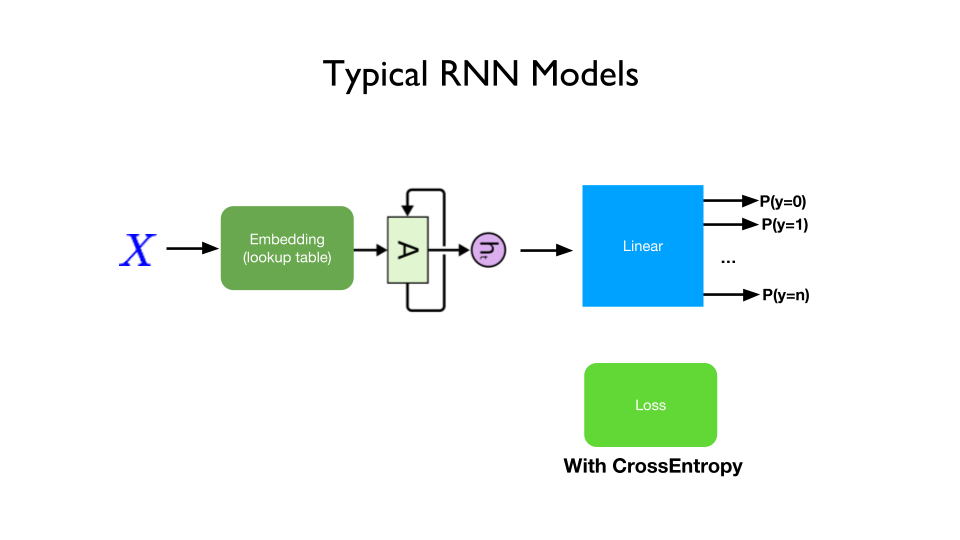

In [4]:
from IPython.display import Image
Image('rnn_typical.png')

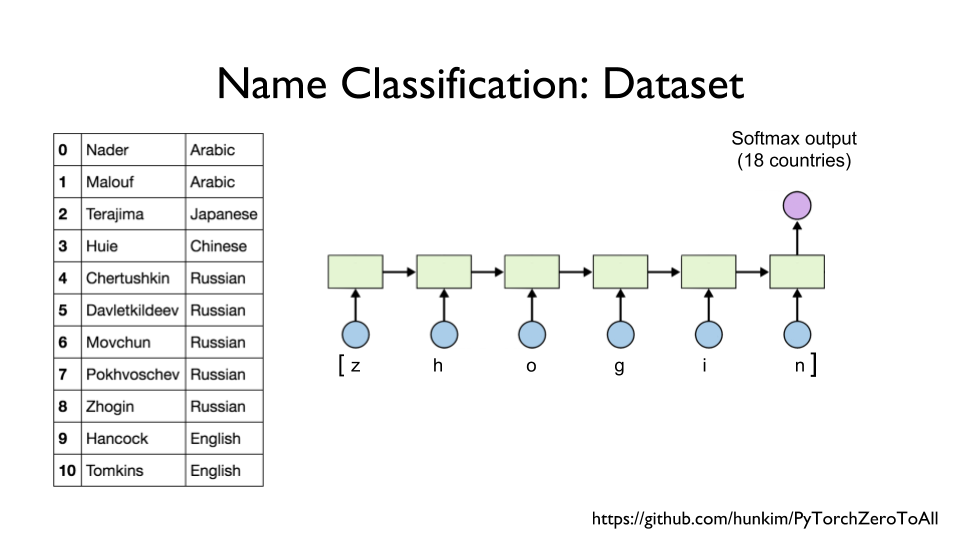

In [5]:
Image('rnn_names.png')

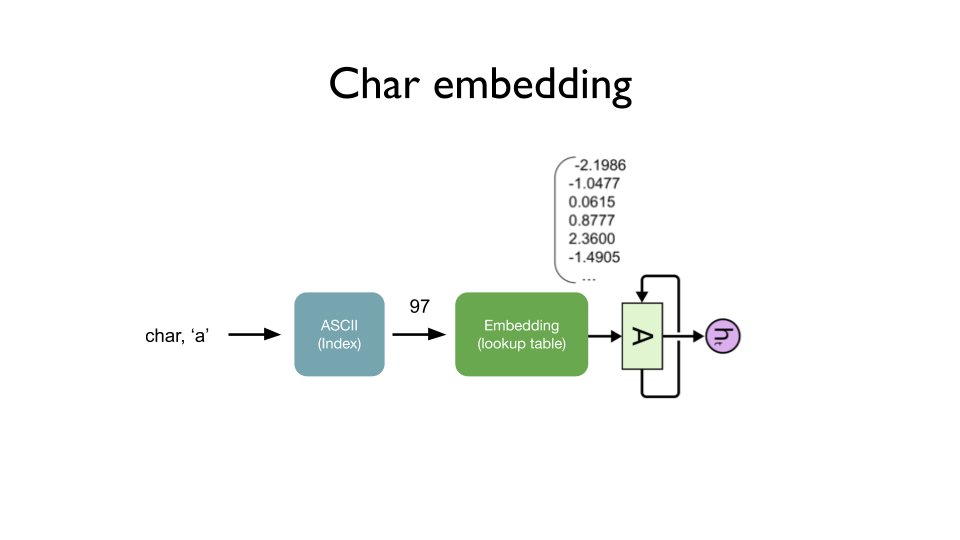

In [6]:
Image('rnn_char_embedding.png')

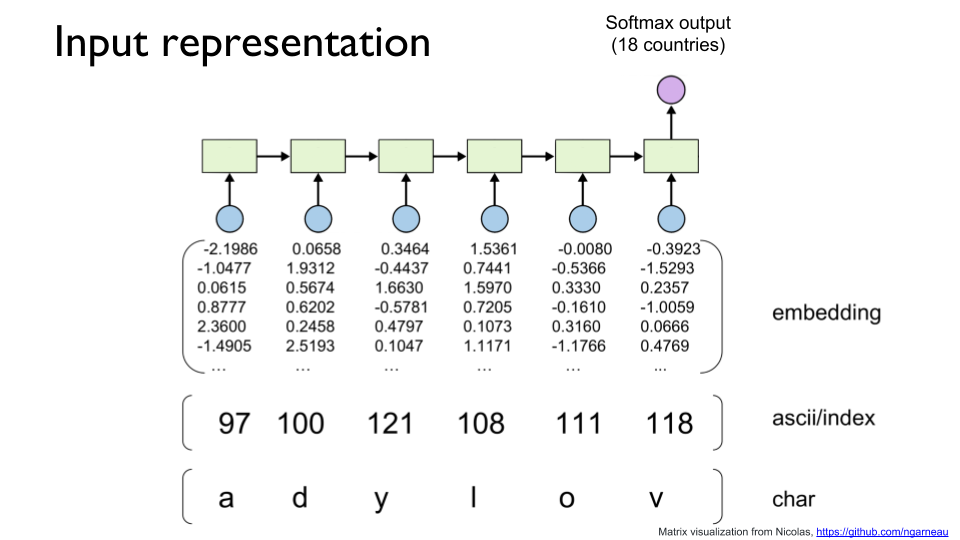

In [7]:
Image('rnn_input_representation.png')

In [8]:
def str2ascii_arr(name):
  arr = [ord(c) for c in name]
  return arr, len(arr)

In [69]:
class RNNClassifier(nn.Module):
  def __init__(self, n_features, hidden_size, num_classes, 
               num_layers = 1):
    super().__init__()
    self.n_features = n_features
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.num_layers = num_layers

    # Layers
    self.embedding = nn.Embedding(n_features, hidden_size)
    # (number of characters in total, RNN input)
    self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, num_classes)
  
  def forward(self,input):
    # input = Batch x Sequence
    batch_size  = input.size(0)

    # input : Batch x Sequence -- (transpose) --> Sequence x Batch
    input = input.t()

    # Embedding SxB -> SxBxI(embedding size)
    print(" input: ", input.size())
    embedded = self.embedding(input)
    print(" embedding: ", embedded.size())
    # print(embedded)
    # Make a hidden
    hidden = self._init_hidden(batch_size)

    output, hidden = self.gru(embedded, hidden)
    print(" gru hidden output: ", hidden.size())

    # Use the last layer output as Fully Connected's inputs
    # No need to unpack, since we are going to use hidden

    fc_output = self.fc(hidden)
    print(" fc output: ", fc_output.size())
    return fc_output

  def _init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
    return Variable(hidden)

In [ ]:
# @title Basic main
n_chars = 128
hidden_size = 100
n_classes = 18

names = ['adylov', 'solan', 'hard', 'san']
classifier = RNNClassifier(n_chars, hidden_size, n_classes)

for name in names:
  arr, _ = str2ascii_arr(name)
  inp = Variable(torch.LongTensor([arr]))
  out = classifier(inp)
  print("in: ", inp.size(), "out: ", out.size())
  print("\n")


## Zero Padding & Batch


In [16]:
# pad sequences and sort the tensor
def pad_sequences(vectorized_seqs, seq_lengths):
  seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()
  for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
  return seq_tensor

In [57]:
# @title Sequence Padding
names = ['adylov', 'solan', 'hard', 'san']
arrs = []
seqs = []
for name in names:
  arr, seq_len = str2ascii_arr(name)
  arrs.append(np.array(arr))
  seqs.append(seq_len)
arrs = np.array(arrs)
seqs = np.array(seqs)
seq_tensor = pad_sequences(arrs, seqs)
print(seq_tensor)
# print(np.array(arrs))
# print(np.array(seqs))


tensor([[ 97, 100, 121, 108, 111, 118],
        [115, 111, 108,  97, 110,   0],
        [104,  97, 114, 100,   0,   0],
        [115,  97, 110,   0,   0,   0]])


In [58]:
# Create necessary variables, length and target
def make_variables(names):
  sequence_and_length = [str2ascii_arr(name) for name in names]
  vectorized_seqs = [sl[0] for sl in sequence_and_length]
  seq_lengths = torch.LongTensor([sl[1] for sl in sequence_and_length])
  return pad_sequences(vectorized_seqs, seq_lengths)

In [59]:
print(make_variables(names))

tensor([[ 97, 100, 121, 108, 111, 118],
        [115, 111, 108,  97, 110,   0],
        [104,  97, 114, 100,   0,   0],
        [115,  97, 110,   0,   0,   0]])


In [68]:
# @title Main with batch

n_chars = 128
hidden_size = 100
n_classes = 18

names = ['adylov', 'solan', 'hard', 'san']
classifier = RNNClassifier(n_chars, hidden_size, n_classes)

inputs = make_variables(names)
out = classifier(inputs)
print("batch in", inputs.size(), "batch out", out.size())


 input:  torch.Size([6, 4])
 embedding:  torch.Size([6, 4, 100])
tensor([[[ 0.3931, -1.1544,  1.5694,  ...,  2.9176,  1.0676, -1.3351],
         [ 1.3416, -0.4760, -1.2479,  ...,  1.4001,  1.3397, -0.0040],
         [ 0.3621, -0.6569,  0.2002,  ..., -0.4348, -0.0720,  0.3387],
         [ 1.3416, -0.4760, -1.2479,  ...,  1.4001,  1.3397, -0.0040]],

        [[ 0.9730,  0.2554,  1.9729,  ..., -1.1349,  0.0664, -1.8414],
         [ 1.4343, -0.9822, -1.9384,  ...,  0.7045, -0.0163,  0.0782],
         [ 0.3931, -1.1544,  1.5694,  ...,  2.9176,  1.0676, -1.3351],
         [ 0.3931, -1.1544,  1.5694,  ...,  2.9176,  1.0676, -1.3351]],

        [[-2.1216, -1.0723, -0.2513,  ...,  0.3219,  0.6159, -0.1007],
         [ 0.9567, -0.9356, -0.4146,  ..., -0.6186,  1.6099, -0.0186],
         [ 0.6276, -1.6018, -0.1258,  ..., -1.2343,  0.0524, -0.0442],
         [ 2.2755,  1.0910, -1.2881,  ..., -0.2732, -0.1098,  2.3052]],

        [[ 0.9567, -0.9356, -0.4146,  ..., -0.6186,  1.6099, -0.0186],
      

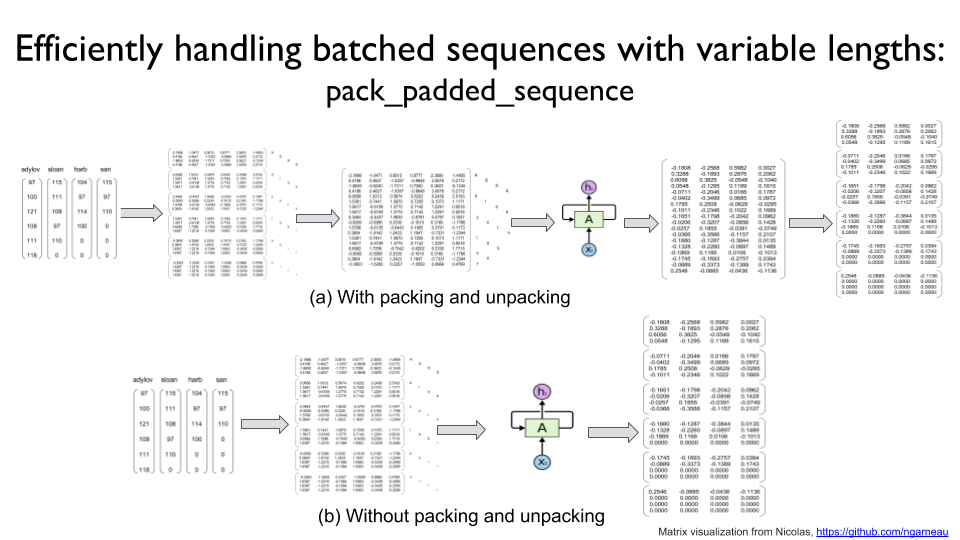

In [72]:
# @title Packing and Unpacking
Image('rnn_pack.png')

In [ ]:
# @title Training
n_chars = 128
hidden_size = 100
n_classes = 18

names = ['adylov', 'solan', 'hard', 'san']
classifier = RNNClassifier(n_chars, hidden_size, n_classes)

inputs = make_variables(names)
out = classifier(inputs)
print("batch in", inputs.size(), "batch out", out.size())
